In [1]:
import pandas as pd
import numpy as np
import vegas
import sys
import os
sys.path.insert(0, "/Users/rocconoe/local/lib/python3.9/site-packages")
import lhapdf

from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import integrate

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

palette = plt.get_cmap('Set1')
%matplotlib inline
%config InlineBackend.figure_format='retina'

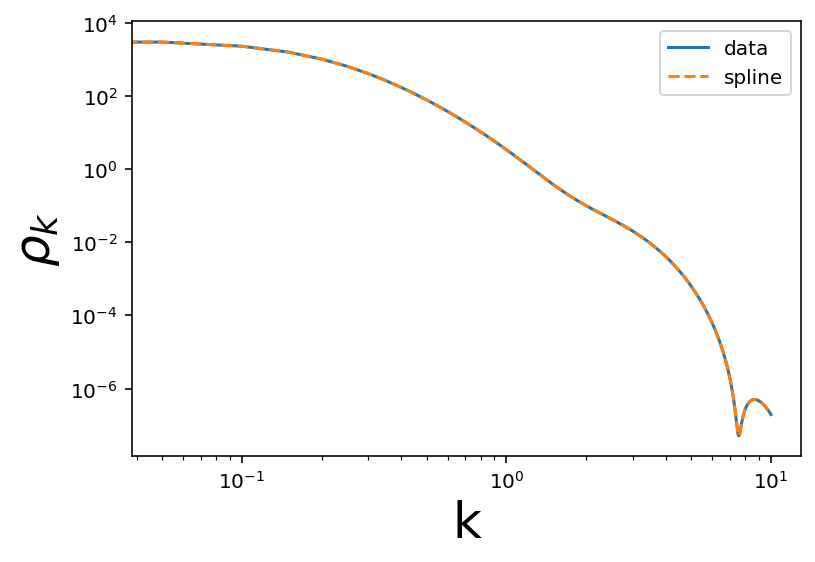

In [2]:
momentum = pd.read_csv('nk_deut.dat', sep='\s+', names=['k','rs','rd','rk'], dtype=np.float64,skiprows=2)
"""Plot the momentum distribution."""
plt.figure(figsize=(6,4));plt.rc('axes', labelsize=25, titlesize=30);plt.plot(momentum['k'],momentum['rk'],label='data');
ps = interp1d(momentum['k'],momentum['rk'], kind='cubic');xnew = np.linspace(0, 10, 200);plt.plot(xnew, ps(xnew),'--',label='spline')
plt.xscale('log');plt.yscale('log');plt.xlabel('k');plt.ylabel(r'$\rho_k$');plt.legend();plt.show()

In [3]:
def psg(pprime):
    hbarc = 197.32*1e-3 ; p = pprime/hbarc
    return ps(p)/hbarc**3 # answer in GeV.

In [4]:
class DIS:
    """ 
    Class to store the PDF, so it is not constantly re-initialized (should be much quicker)
    """
    def __init__(self, name, set_id):
        self.pdf = lhapdf.mkPDF(name, set_id)
        self.xfxQ2_vec = np.vectorize(self.__call__)

    def __call__(self, i, x, q2):
        return self.pdf.xfxQ2(i, x, q2)
    
    def F2p(self, x, q2):
        charge2 = [4/9, 1/9]
        result = 0
        for i in range(1, 6):
            result += charge2[i%2]*(self.xfxQ2_vec(i, x, q2) + self.xfxQ2_vec(-i, x, q2))
            
        return result
    def F2n(self, x, q2):
        charge2 = [1/9, 4/9]
        result = 0
        for i in range(1, 6):
            result += charge2[i%2]*(self.xfxQ2_vec(i, x, q2) + self.xfxQ2_vec(-i, x, q2))
            
        return result
    
    def F1p(self, x, q2):
        return self.F2p(x, q2)/(2*x)
    
    def F1n(self, x, q2):
        return self.F2n(x, q2)/(2*x)

In [5]:
m_p       = 0.938    # mass of proton in GeV.
m_n       = 0.939    # mass of neutron in GeV.
M_A = m_p # entire deuteron nucleus mass.

In [6]:
class deut_DIS_dbl:
    def __init__(self, xa, pdf):
        self.pdf = DIS(pdf, 0)       
        self.xa  = xa
#        self.E   = E
    
    def qvec(self,q2):
        return np.sqrt(q2+self.omega(q2)**2)
    def omega(self,q2):
        return q2/(2*M_A*self.xa)
    def omega_t(self,p,m,q2):
        wt=self.omega(q2)-2*np.sqrt(p**2+m**2)+2*m-0.002
      #  if (wt<0):
      #      wt=self.omega(q2)
        return wt
    def q2t(self,q2,p,m):
        return self.qvec(q2)**2-self.omega_t(p,m,q2)**2
        
    def phase_space(self,p,m,flag):
        if(flag==True):
            ph_sp=2*np.pi*p**2*psg(p)/(2*np.pi)**3*m/np.sqrt(p**2+m**2)#
        else:
            ph_sp= 1
        return ph_sp
        
    def xn(self,p,m,cosT,q2):
        if(p==0):
            return self.xa
        else:
            ep=np.sqrt(p**2+m**2)
            pdotq=ep*self.omega(self.q2)-p*cosT*self.qvec(self.q2)
            return q2/2/pdotq
        
    def f2A(self, p,costh, q2):
        self.q2=q2
        sinth = np.sqrt(1-costh**2)
        #dI = np.zeros_like(self.q2_bins)
        ep=np.sqrt(p**2+m_p**2)
        pdotq=ep*self.omega_t(p,m_p,self.q2)-p*costh*self.qvec(self.q2)

        x_p=self.xn(p,m_p,costh,self.q2)
        I=0
        if x_p < 0 or x_p > 1:
            return I
        else:
            q2t=self.q2t(q2,p,m_p)
            term1=self.omega(self.q2)*self.pdf.F1p(x_p,q2t)/m_p*self.q2/self.qvec(self.q2)**2*(1-self.q2/self.q2t(self.q2,p,m_p))
            term2=self.q2**2/self.qvec(self.q2)**4*self.pdf.F2p(x_p,q2t)/m_p**2*(ep+(pdotq)/self.q2t(q2,p,m_p)*self.omega_t(p,m_p,self.q2))**2
            term3=self.q2/self.qvec(self.q2)**2*1/2*p**2*sinth**2*self.pdf.F2p(x_p,q2t)/m_p**2
            f2p=term1+term2+term3
            term1=self.omega(self.q2)*self.pdf.F1n(x_p,q2t)/m_p*self.q2/self.qvec(self.q2)**2*(1-self.q2/self.q2t(self.q2,p,m_p))
            term2=self.q2**2/self.qvec(self.q2)**4*self.pdf.F2n(x_p,q2t)/m_p**2*(ep+(pdotq)/self.q2t(q2,p,m_p)*self.omega_t(p,m_p,self.q2))**2
            term3=self.q2/self.qvec(self.q2)**2*1/2*p**2*sinth**2*self.pdf.F2n(x_p,q2t)/m_p**2
            f2n=term1+term2+term3       
            # self.pdf.F1p(x_p,self.q2)*self.q2/self.qvec(self.q2)**2*(self.q2/self.q2t(self.q2,p,m_p)-1)  
            
            
            I = self.phase_space(p,m_p,True)*(f2p+f2n)
          #  j = np.searchsorted(self.q2_bins, self.q2)

          #  dI[j] = I/np.diff(self.q2_bins)[j-1]
          #  if np.any(dI < 0):
          #      print(dI)
        
        return I
    
    def f1A(self, p,costh, q2):
        self.q2=q2
        
        sinth = np.sqrt(1-costh**2)

        x_p=self.xn(p,m_p,costh,self.q2)
        I=0
        if x_p < 0 or x_p > 1:
            return I
        else:

            f1p=M_A*(self.pdf.F1p(x_p,self.q2)/m_p 
                +self.pdf.F2p(x_p,self.q2)*1/2/self.omega(self.q2)*p**2*sinth**2/m_p**2)
            f1n=M_A*(self.pdf.F1n(x_p,self.q2)/m_p 
                +self.pdf.F2n(x_p,self.q2)*1/2/self.omega(self.q2)*p**2*sinth**2/m_p**2)
        
            I = self.phase_space(p,m_p,True)*(f1p+f1n)
            #I=f1p
            #j = np.searchsorted(self.q2_bins, self.q2)


            #dI[j] = I/np.diff(self.q2_bins)[j-1]
            #if np.any(dI < 0):
            #    print(dI)
        
        return I

In [10]:
experimental = pd.read_csv('HEPData-ins280954-v1-Table_1.csv', header=12, names=['Q2', 'F2', 'stat+', 'stat-', 'sys+', 'sys-'], dtype=np.float64)
experimental['error'] = np.sqrt(experimental['stat+']**2 + experimental['sys+']**2)
experimental['Q2'].to_numpy()

array([0.583, 0.662, 0.811, 0.893, 1.013, 1.116, 1.255, 1.44 , 1.531,
       1.662, 1.801, 1.979, 2.153, 2.419])

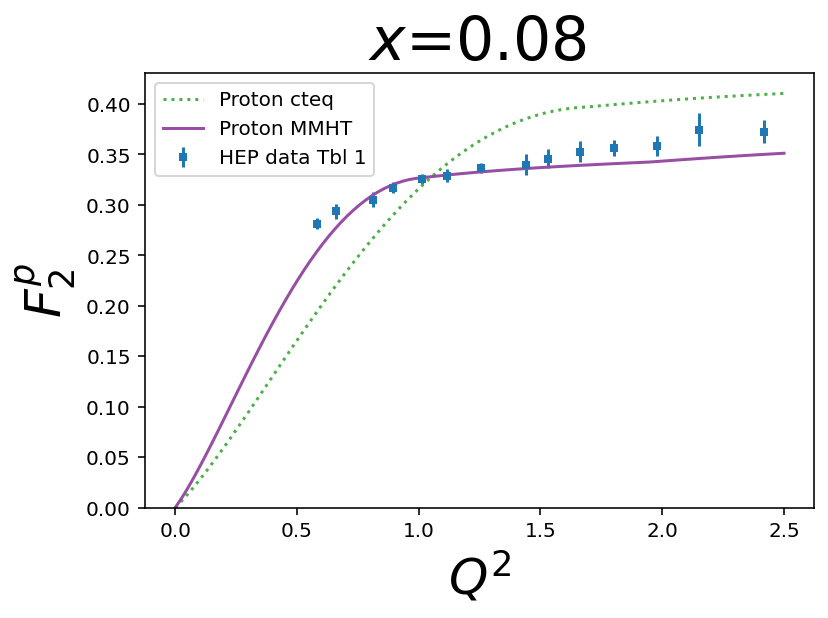

In [11]:
dis = DIS("MMHT2014lo68cl", 0)
dis_ct14lo = DIS("CT14nlo", 0)
dis_ct10 = DIS("CT10", 0)
dis_cteq66= DIS("cteq66", 0)

x=0.08
q2=np.linspace(0,2.5,100)
plt.plot(q2, dis_cteq66.F2p(x, q2),color=palette(2),linestyle=':',label='Proton cteq') 
plt.plot(q2, dis.F2p(x, q2),color=palette(3),linestyle='-',label='Proton MMHT') 

plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='HEP data Tbl 1', ls='', marker='s', markersize='3')

plt.title(r'$x$=0.08 ')
plt.xlabel(r'$Q^2$')
plt.ylabel(r'$F_{2}^{p}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,)
plt.legend(loc=0, ncol=1)
plt.savefig('f2p_compare.pdf', bbox_inches='tight')

In [13]:
x=0.08
nq=10
integral=np.zeros((nq,2))


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
q2=np.linspace(0.1,2.5,nq)
for i in range(nq):
    integral[i,:]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],),epsabs=1.49e-03)
    print(integral[i,:])

[8.25667541e-02 5.34510349e-05]
[3.39051671e-01 2.21936764e-04]
[5.13891105e-01 3.45058028e-04]
[5.79996999e-01 5.36468983e-04]
[5.94129672e-01 4.01409310e-04]
[6.03667238e-01 3.77439780e-04]
[6.11125918e-01 4.62566946e-04]
[6.18349871e-01 4.21344001e-04]
[6.25070183e-01 4.27352556e-04]
[6.30618933e-01 4.28296876e-04]


In [185]:
experimental = pd.read_csv('HEPData-ins280954-v1-Table_13.csv', header=10, names=['Q2', 'F2', 'stat+', 'stat-', 'sys+', 'sys-'], dtype=np.float64)
experimental['error'] = np.sqrt(experimental['stat+']**2 + experimental['sys+']**2)
experimental['Q2'].to_numpy()

array([0.582, 0.662, 0.811, 0.893, 1.012, 1.117, 1.24 , 1.44 , 1.532,
       1.661, 1.808, 1.993, 2.146, 2.419])

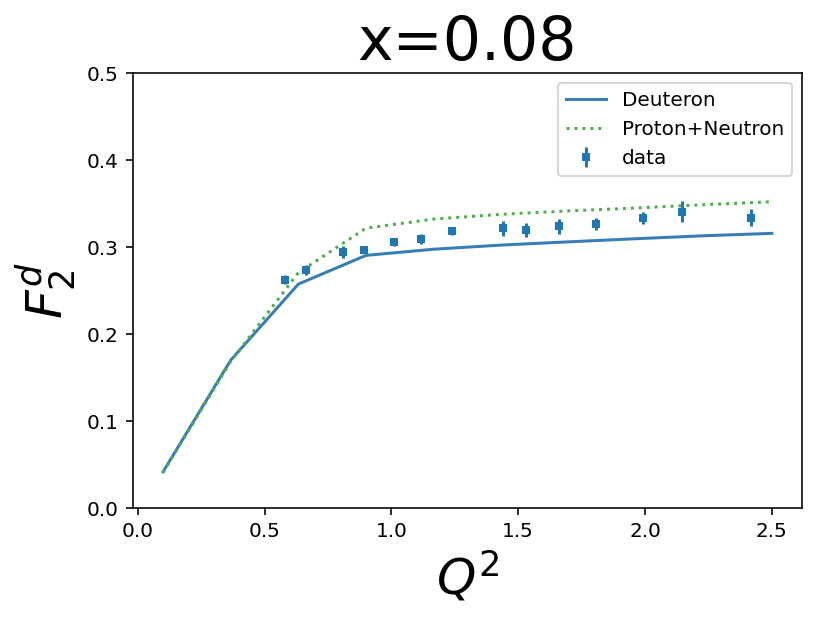

In [188]:
x=0.08
# Experiment
#mask = experimental['Q2']
#exp = experimental[ma


dis_ct14lo=DIS("MMHT2014lo68cl", 0)
plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='data', ls='', marker='s', markersize='3')
plt.plot(q2,integral[:,0]/2, color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2,color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')


plt.title(r'x=0.08')
plt.xlabel(r'$Q^2$')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,0.5)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_0p08_set1.pdf', bbox_inches='tight')





In [168]:
x=0.08
nq=10
integral=np.zeros((nq,2))


deut_Q2 = deut_DIS_dbl(x,pdf='CT14lo')
q2=np.linspace(0.1,2.5,nq)
for i in range(nq):
    integral[i,:]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],),epsabs=1.49e-04)
    print(integral[i,:])

[5.32208974e-02 3.46007602e-05]
[2.33090333e-01 1.48811658e-04]
[4.05017554e-01 6.83056070e-05]
[5.35970601e-01 8.84914301e-05]
[6.17146201e-01 1.03699470e-04]
[6.53076471e-01 1.14316466e-04]
[6.60785951e-01 1.15697582e-04]
[6.64954991e-01 1.16936331e-04]
[6.68294795e-01 1.16960883e-04]
[6.71101725e-01 1.17475740e-04]


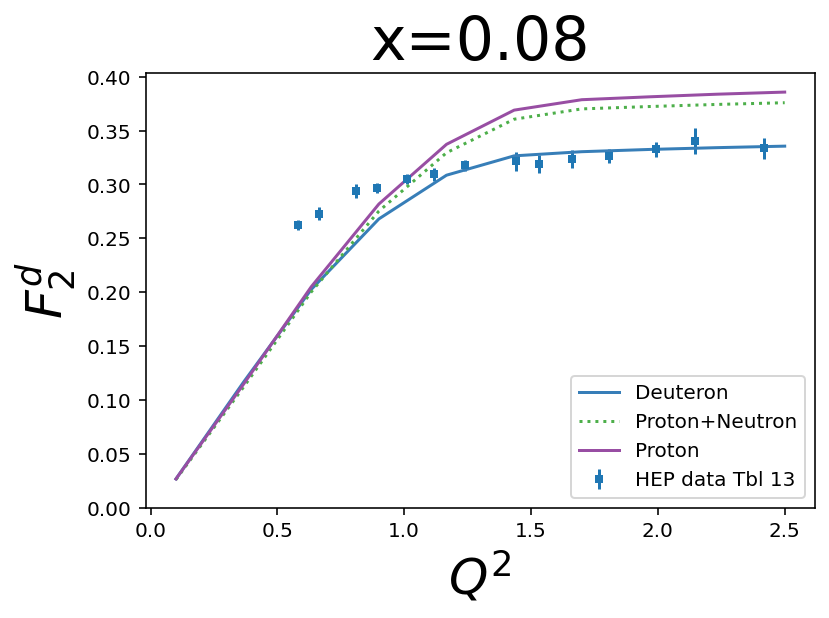

In [169]:
x=0.08
# Experiment
#mask = experimental['Q2']
#exp = experimental[mask]
dis_ct14lo=DIS("CT14lo", 0)
plt.errorbar(experimental_d['Q2'], experimental_d['F2'], yerr=experimental_d['error'], label='HEP data Tbl 13', ls='', marker='s', markersize='3')
plt.plot(q2,integral[:,0]/2, color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2,color=palette(2),linestyle=':',label='Proton+Neutron')
plt.plot(q2, dis_ct14lo.F2p(x, q2),color=palette(3),linestyle='-',label='Proton')


plt.title(r'x=0.08')
plt.xlabel(r'$Q^2$')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_compare.pdf', bbox_inches='tight')

In [189]:
experimental = pd.read_csv('HEPData-ins262063-v1-Table_1.csv', header=29, names=['Q2', 'F2', 'error+', 'error-'], dtype=np.float64)
experimental['error'] = experimental['error+']
experimental['Q2'].to_numpy()

array([1. , 1.5, 2.5, 5. ])

In [190]:
x=0.2
nq=15
integral=np.zeros((nq,2))


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
q2=np.linspace(0.05,5.0,nq)
for i in range(nq):
    integral[i,:]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],),epsabs=1.49e-04)
    print(integral[i,:])

[3.56805955e-02 2.41315094e-05]
[3.68664006e-01 6.16359223e-05]
[5.70193049e-01 9.95343161e-05]
[5.91945883e-01 1.01988918e-04]
[5.86986651e-01 1.03535779e-04]
[5.82692908e-01 1.01748731e-04]
[5.79956901e-01 1.00339017e-04]
[5.77624461e-01 1.00049319e-04]
[5.75352774e-01 9.97419368e-05]
[5.73237466e-01 9.94630281e-05]
[5.71261394e-01 9.91741805e-05]
[5.69415026e-01 9.89158311e-05]
[5.67683946e-01 9.86513914e-05]
[5.66056702e-01 9.84182525e-05]
[5.64525081e-01 9.81822516e-05]


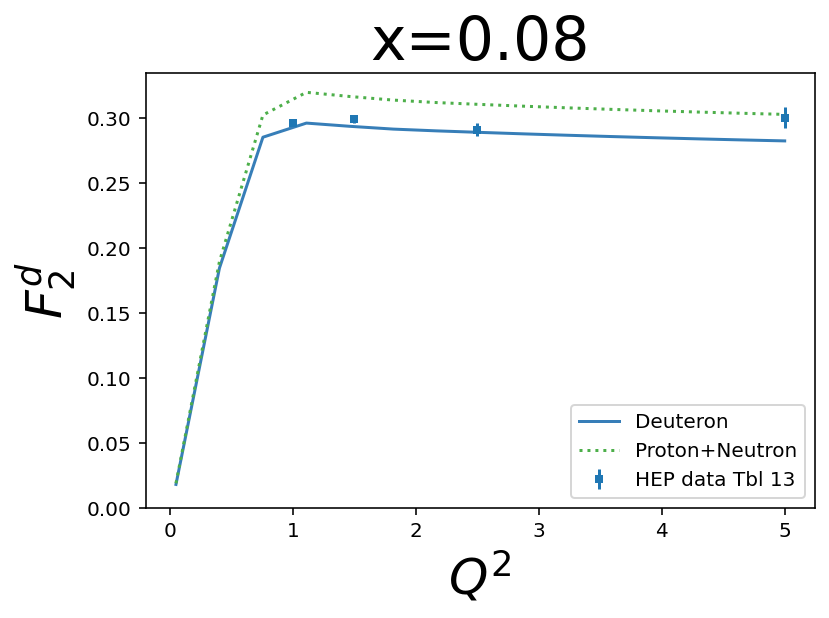

In [191]:
x=0.2
# Experiment
#mask = experimental['Q2']
#exp = experimental[ma


dis_ct14lo=DIS("MMHT2014lo68cl", 0)
plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='HEP data Tbl 13', ls='', marker='s', markersize='3')
plt.plot(q2,integral[:,0]/2, color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2,color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')


plt.title(r'x=0.08')
plt.xlabel(r'$Q^2$')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_p08.pdf', bbox_inches='tight')

In [177]:
experimental = pd.read_csv('HEPData-ins188737-v1-Table_5.csv', header=10, names=['Q2', 'F2', 'error+', 'error-'], dtype=np.float64)
experimental['error'] = experimental['error+']
experimental['Q2'].to_numpy()

array([11.5, 15. , 20. , 27. , 36. , 48. , 65. ])

In [178]:
x=0.175
nq=20
integral=np.zeros((nq,2))


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
q2=np.linspace(11,65.0,nq)
for i in range(nq):
    integral[i,:]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],),epsabs=1.49e-04)
    print(integral[i,:])

[5.73129945e-01 9.97870593e-05]
[5.69276984e-01 9.84918104e-05]
[5.66087279e-01 9.77888487e-05]
[5.63407955e-01 9.94753503e-05]
[5.61231140e-01 9.78879681e-05]
[5.59567915e-01 9.76900729e-05]
[5.58010727e-01 9.74175405e-05]
[5.56574144e-01 9.71932338e-05]
[5.55245661e-01 9.69838710e-05]
[5.54013447e-01 9.67938189e-05]
[5.52866114e-01 9.66158583e-05]
[5.51790599e-01 9.64471598e-05]
[5.5077761e-01 9.6286817e-05]
[5.49820715e-01 9.61331673e-05]
[5.48914400e-01 9.59862201e-05]
[5.48053887e-01 9.58507802e-05]
[5.47234991e-01 9.57189935e-05]
[5.46453986e-01 9.55923621e-05]
[5.45707421e-01 9.54767942e-05]
[5.44991661e-01 9.53585916e-05]


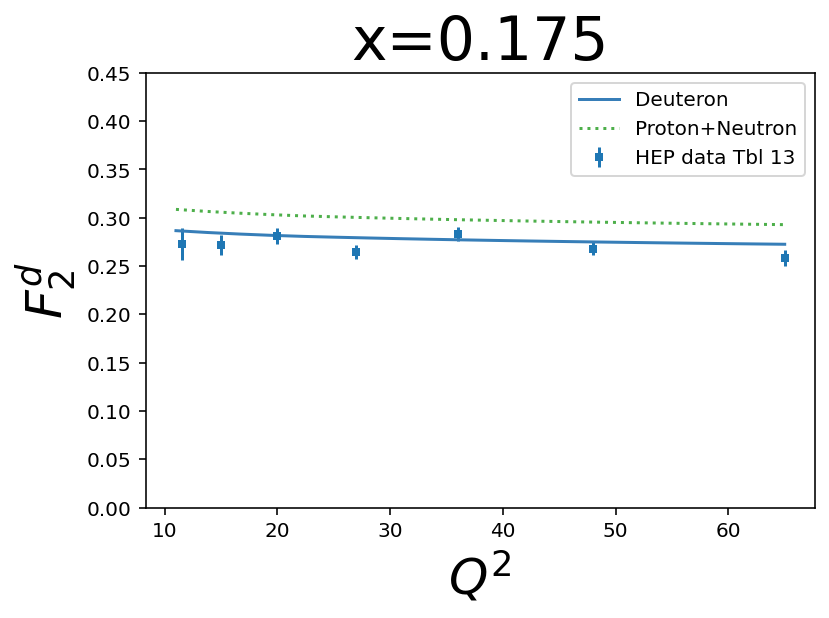

In [181]:
# Experiment
#mask = experimental['Q2']
#exp = experimental[ma


dis_ct14lo=DIS("MMHT2014lo68cl", 0)
plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='HEP data Tbl 13', ls='', marker='s', markersize='3')
plt.plot(q2,integral[:,0]/2, color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2,color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')


plt.title(r'x=0.175')
plt.xlabel(r'$Q^2$')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,0.45)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_p175.pdf', bbox_inches='tight')

In [204]:
experimental = pd.read_csv('HEPData-ins188737-v1-Table_6.csv', header=10, names=['Q2', 'F2', 'error+', 'error-'], dtype=np.float64)
experimental['error'] = experimental['error+']
experimental['Q2'].to_numpy()

array([11.5, 15. , 20. , 27. , 36. , 48. , 65. , 90. ])

In [205]:
x=0.25
nq=20
integral=np.zeros((nq,2))


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
q2=np.linspace(10,90.0,nq)
for i in range(nq):
    integral[i,:]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],),epsabs=1.49e-04)
    print(integral[i,:])

[4.93819034e-01 8.65170672e-05]
[4.82595691e-01 8.45774714e-05]
[4.74534266e-01 8.40368938e-05]
[4.68266723e-01 8.22969007e-05]
[4.63522914e-01 8.15148589e-05]
[4.59489410e-01 8.08514399e-05]
[4.55997320e-01 8.02705924e-05]
[4.52939285e-01 7.97624378e-05]
[4.50221775e-01 7.93095780e-05]
[4.47774967e-01 7.89046192e-05]
[4.45551836e-01 7.85342952e-05]
[4.43516509e-01 7.81953522e-05]
[4.41641015e-01 7.78826052e-05]
[4.39903168e-01 7.75917532e-05]
[4.38285096e-01 7.73219369e-05]
[4.36772094e-01 7.70697493e-05]
[4.35351967e-01 7.68328153e-05]
[4.34014499e-01 7.66077005e-05]
[4.32751048e-01 7.63962117e-05]
[4.31554241e-01 7.61958684e-05]


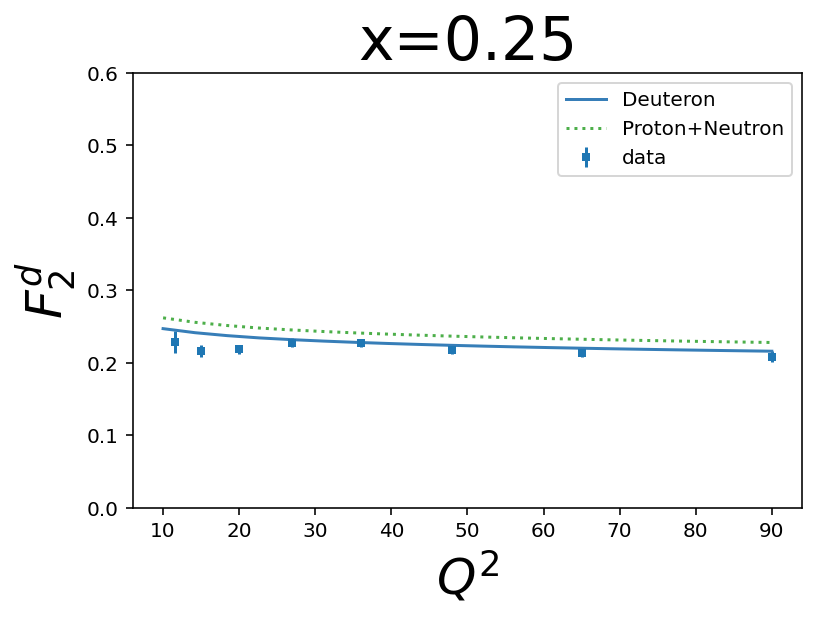

In [208]:
dis_ct14lo=DIS("MMHT2014lo68cl", 0)
plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='data', ls='', marker='s', markersize='3')
plt.plot(q2,integral[:,0]/2, color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2,color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')


plt.title(r'x=0.25')
plt.xlabel(r'$Q^2$')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,0.6)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_x0p125_q210t60.pdf', bbox_inches='tight')

In [199]:
experimental = pd.read_csv('HEPData-ins188737-v1-Table_4.csv', header=10, names=['Q2', 'F2', 'error+', 'error-'], dtype=np.float64)
experimental['error'] = experimental['error+']
experimental['Q2'].to_numpy()

array([ 9. , 11.5, 15. , 20. , 27. , 36. , 48. , 65. ])

In [200]:
x=0.125
nq=20
integral=np.zeros((nq,2))


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
q2=np.linspace(9,65.0,nq)
for i in range(nq):
    integral[i,:]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],),epsabs=1.49e-04)
    print(integral[i,:])

[6.24006781e-01 1.08787185e-04]
[6.24021852e-01 1.07596085e-04]
[6.23596069e-01 1.08134349e-04]
[6.23167290e-01 1.10495605e-04]
[6.22885068e-01 1.10274450e-04]
[6.23020210e-01 1.08904509e-04]
[6.23095987e-01 1.08933906e-04]
[6.23070443e-01 1.08964891e-04]
[6.22991283e-01 1.08973579e-04]
[6.22876184e-01 1.08974722e-04]
[6.22736461e-01 1.08976736e-04]
[6.22577909e-01 1.08973241e-04]
[6.22405065e-01 1.08958282e-04]
[6.22222771e-01 1.08947499e-04]
[6.22034518e-01 1.08939180e-04]
[6.21842801e-01 1.08918431e-04]
[6.21649360e-01 1.08886722e-04]
[6.21455296e-01 1.08885268e-04]
[6.21260992e-01 1.08846694e-04]
[6.21065703e-01 1.08828239e-04]


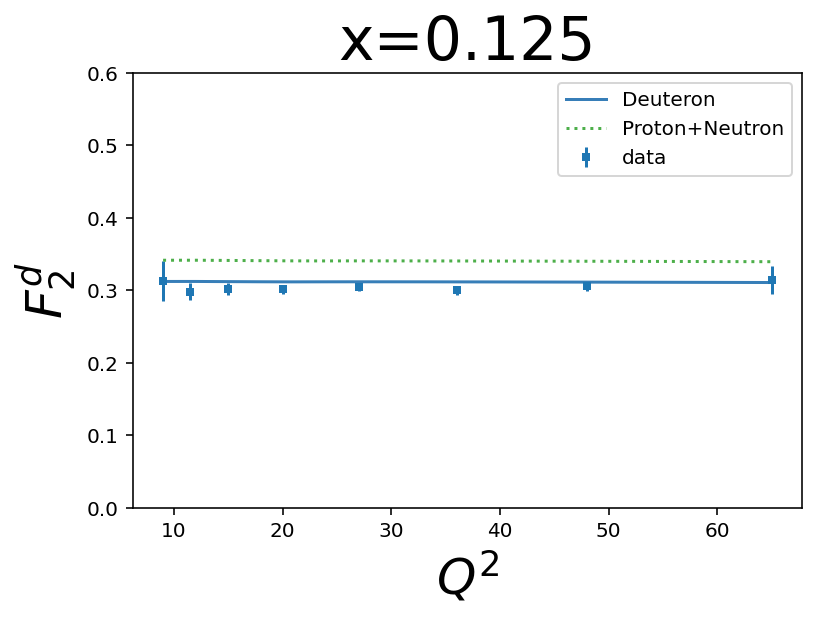

In [203]:
dis_ct14lo=DIS("MMHT2014lo68cl", 0)
plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='data', ls='', marker='s', markersize='3')
plt.plot(q2,integral[:,0]/2, color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2, (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2,color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')


plt.title(r'x=0.125')
plt.xlabel(r'$Q^2$')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,0.6)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_x0p125_q210t60.pdf', bbox_inches='tight')

# Helium calculation

In [7]:
fname_pke='pke_he4.out'
nE=300
npp=200
hbarc=197.32
mev_to_gev=1e-3
en=np.zeros(nE)
pp=np.zeros(npp)

sf_he4=np.zeros((nE,npp))
val1,val2,val3=np.loadtxt(fname_pke, unpack=True,usecols=(0,1,4))


            
for j in range (0,npp):
    pp[j]=val1[j*nE]
    for i in range (0,nE):
        en[i]= val2[i]
        sf_he4[i,j]=val3[i + j*nE]
        #print(pp[j],en[i],sf_he4[i,j])
        if(sf_he4[i,j]<0):
            sf_he4[i,j]=0  
            
            
pp=pp*hbarc*mev_to_gev
en=en*mev_to_gev
sf_he4=sf_he4/(2.0*np.pi)**3/hbarc**3/mev_to_gev**4

hen=en[2]-en[1]

norm=0    
dpp=np.zeros(npp)


for j in range (npp):
    dpp[j]=np.sum(sf_he4[:,j])*hen
    norm+=dpp[j]*pp[j]**2*4*np.pi*(pp[2]-pp[1])  
#norm=np.sum(dpp*pp**2)*4*np.pi*(pp[2]-pp[1])    
    


In [8]:

pke_int = interpolate.RectBivariateSpline(en, pp ,sf_he4)

e=np.linspace(0,0.250,200)
p = np.linspace(0,0.800,1000)

dpp_int2=np.zeros(1000)
for j in range (1000):
    for i in range (200):
        dpp_int2[j]+=pke_int(e[i],p[j])*(e[2]-e[1])
        

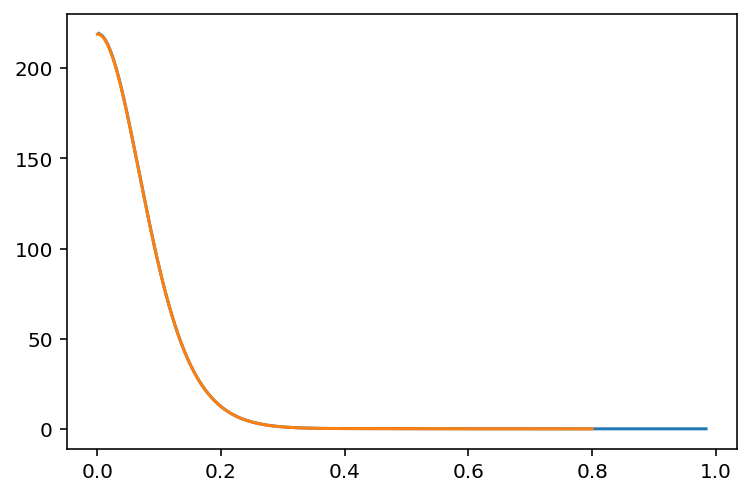

In [8]:
plt.plot(pp,dpp)
plt.plot(p,dpp_int2)  

In [9]:
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
p = np.linspace(0,0.600,2000)
dpp_int = interpolate.InterpolatedUnivariateSpline(pp, dpp)
res = integrate.simps(dpp_int(p)*p**2*4*np.pi,p)
print(res)

1.9413020191216324


In [10]:
m_p=0.938

class nucl_DIS_dbl:
    def __init__(self, xa, sf, pp, ee, pdf):
        self.pdf = DIS(pdf, 0)       
        self.xa  = xa
        self.pke= interpolate.RectBivariateSpline(ee, pp ,sf)
#        self.E   = E
    
    def qvec(self,q2):
        return np.sqrt(q2+self.omega(q2)**2)
    def omega(self,q2):
        return q2/(2*M_A*self.xa)
    def omega_t(self,p,e,m,q2):
        wt=self.omega(q2)-e+m-np.sqrt(p**2+m**2)
      #  if (wt<0):
      #      wt=self.omega(q2)
        return wt
    def q2t(self,q2,p,e,m):
        return self.qvec(q2)**2-self.omega_t(p,e,m,q2)**2
        
    def phase_space(self,p,e,m,flag):
        if(flag==True):
            ph_sp=2*np.pi*p**2*self.pke(e,p)*m/np.sqrt(p**2+m**2)#
        else:
            ph_sp= 1
        return ph_sp
        
    def xn(self,p,m,cosT,q2):
        if(p==0):
            return self.xa
        else:
            ep=np.sqrt(p**2+m**2)
            pdotq=ep*self.omega(self.q2)-p*cosT*self.qvec(self.q2)
            return q2/2/pdotq
        
    def f2A(self, p,e,costh,q2):
        self.q2=q2
        sinth = np.sqrt(1-costh**2)
        #dI = np.zeros_like(self.q2_bins)
        ep=np.sqrt(p**2+m_p**2)
        pdotq=ep*self.omega_t(p,e, m_p,self.q2)-p*costh*self.qvec(self.q2)

        x_p=self.xn(p,m_p,costh,self.q2)
        I=0
        if x_p < 0 or x_p > 1:
            return I
        else:
            q2t=self.q2t(q2,p,e,m_p)
            term1=self.omega(self.q2)*self.pdf.F1p(x_p,q2t)/m_p*self.q2/self.qvec(self.q2)**2*(1-self.q2/self.q2t(self.q2,p,e,m_p))
            term2=self.q2**2/self.qvec(self.q2)**4*self.pdf.F2p(x_p,q2t)/m_p**2*(ep+(pdotq)/self.q2t(q2,p,e,m_p)*self.omega_t(p,e,m_p,self.q2))**2
            term3=self.q2/self.qvec(self.q2)**2*1/2*p**2*sinth**2*self.pdf.F2p(x_p,q2t)/m_p**2
            f2p=term1+term2+term3
            term1=self.omega(self.q2)*self.pdf.F1n(x_p,q2t)/m_p*self.q2/self.qvec(self.q2)**2*(1-self.q2/self.q2t(self.q2,p,e,m_p))
            term2=self.q2**2/self.qvec(self.q2)**4*self.pdf.F2n(x_p,q2t)/m_p**2*(ep+(pdotq)/self.q2t(q2,p,e,m_p)*self.omega_t(p,e,m_p,self.q2))**2
            term3=self.q2/self.qvec(self.q2)**2*1/2*p**2*sinth**2*self.pdf.F2n(x_p,q2t)/m_p**2
            f2n=term1+term2+term3       
            # self.pdf.F1p(x_p,self.q2)*self.q2/self.qvec(self.q2)**2*(self.q2/self.q2t(self.q2,p,m_p)-1)  
            
            
            I = self.phase_space(p,e,m_p,True)*(f2p+f2n)
          #  j = np.searchsorted(self.q2_bins, self.q2)

          #  dI[j] = I/np.diff(self.q2_bins)[j-1]
          #  if np.any(dI < 0):
          #      print(dI)
        
        return I
    
    def f1A(self, p, e, costh, q2):
        self.q2=q2
        
        sinth = np.sqrt(1-costh**2)

        x_p=self.xn(p,m_p,costh,self.q2)
        I=0
        if x_p < 0 or x_p > 1:
            return I
        else:

            f1p=M_A*(self.pdf.F1p(x_p,self.q2)/m_p 
                +self.pdf.F2p(x_p,self.q2)*1/2/self.omega(self.q2)*p**2*sinth**2/m_p**2)
            f1n=M_A*(self.pdf.F1n(x_p,self.q2)/m_p 
                +self.pdf.F2n(x_p,self.q2)*1/2/self.omega(self.q2)*p**2*sinth**2/m_p**2)
        
            I = self.phase_space(p,e,m_p,True)*(f1p+f1n)
            #I=f1p
            #j = np.searchsorted(self.q2_bins, self.q2)


            #dI[j] = I/np.diff(self.q2_bins)[j-1]
            #if np.any(dI < 0):
            #    print(dI)
        
        return I

In [11]:
x=0.125
nq=10
integral_he4=np.zeros((nq,2))

helium_Q2 = nucl_DIS_dbl(x,sf_he4,pp,en,pdf='MMHT2014lo68cl')
q2=np.linspace(9,65.0,nq)

for i in range(nq):
    integral_he4[i,:]=integrate.tplquad(helium_Q2.f2A, -1,1, 0.0,0.6, 0.0, 0.4, args=(q2[i],),epsabs=1.49e-02, epsrel=1.49e-02)
    print(integral_he4[i,:])

[1.09224978 0.66699276]
[1.09181687 0.70631578]
[1.09234846 0.3924316 ]
[1.0924879  0.37894022]
[1.09211941 0.36942394]
[1.09152073 0.36200726]
[1.09082216 0.35699486]
[1.09008501 0.35096134]
[1.08932758 0.34587068]
[1.08856693 0.34248317]


In [12]:
x=0.125
nq=10
integral=np.zeros((nq,2))


deut_Q2 = deut_DIS_dbl(x,pdf='MMHT2014lo68cl')
q2=np.linspace(9,65.0,nq)
for i in range(nq):
    integral[i,:]=integrate.dblquad(deut_Q2.f2A, -1,1, 0.0, 0.4, args=(q2[i],),epsabs=1.49e-03)
    print(integral[i,:])

[6.24000009e-01 4.26560970e-04]
[6.23538404e-01 4.26024176e-04]
[6.22859500e-01 4.37570903e-04]
[6.23088112e-01 4.26675486e-04]
[6.22937014e-01 4.26699614e-04]
[6.22643734e-01 4.26637853e-04]
[6.22277601e-01 4.26475509e-04]
[6.21878863e-01 4.26349084e-04]
[6.21470132e-01 4.26188866e-04]
[6.21058971e-01 4.25845805e-04]


In [13]:
experimental = pd.read_csv('HEPData-ins188737-v1-Table_4.csv', header=10, names=['Q2', 'F2', 'error+', 'error-'], dtype=np.float64)
experimental['error'] = experimental['error+']
experimental['Q2'].to_numpy()

array([ 9. , 11.5, 15. , 20. , 27. , 36. , 48. , 65. ])

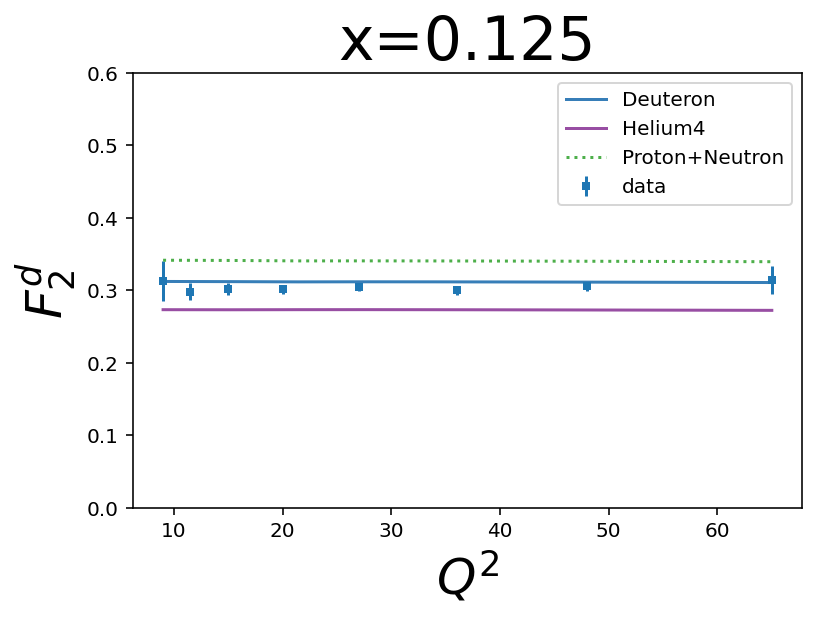

In [14]:
dis_ct14lo=DIS("MMHT2014lo68cl", 0)
plt.errorbar(experimental['Q2'], experimental['F2'], yerr=experimental['error'], label='data', ls='', marker='s', markersize='3')
plt.plot(q2,integral[:,0]/2, color=palette(1),linestyle='-',label='Deuteron')
plt.plot(q2,integral_he4[:,0]/4, color=palette(3),linestyle='-',label='Helium4')

plt.plot(q2, (dis_ct14lo.F2p(x, q2)+dis_ct14lo.F2n(x, q2))/2,color=palette(2),linestyle=':',label='Proton+Neutron')
#plt.plot(q2, dis_ct14lo.F2n(x, q2),color=palette(3),linestyle='-',label='Proton')


plt.title(r'x=0.125')
plt.xlabel(r'$Q^2$')
plt.ylabel(r'$F_{2}^{d}$')
#plt.xlim(0.,0.5)
plt.ylim(0.,0.6)
plt.legend(loc=0, ncol=1)
plt.savefig('f2d_x0p125_q210t60.pdf', bbox_inches='tight')